# Task4 Maciej Wiśniewski Mateusz Wójcicki

In [20]:
import sys
import time
import tracemalloc
import matplotlib.pyplot as plt
import string
import random
from collections import deque 
from typing import List, Dict, Tuple, Optional, Any 

sys.setrecursionlimit(10**6) # moze wystarczy :)

### Algorytmy

Impelmentacje oparte o algorytmy z poprzednich laboratoriów( lekko zmienione w celach analizy danych)

In [21]:
def naive_pattern_match_modified(text: str, pattern: str) -> tuple[list[int], int]:
    comparisons = 0
    if not pattern or not text or len(pattern) > len(text):
        return [], comparisons
    
    n_text = len(text)
    m_pattern = len(pattern)
    positions = []
    
    for i in range(n_text - m_pattern + 1):
        match = True
        for j in range(m_pattern):
            comparisons += 1 
            if text[i + j] != pattern[j]:
                match = False
                break
        if match:
            positions.append(i)
            
    return positions, comparisons

In [22]:
def compute_lps_array_modified(pattern: str) -> tuple[list[int], int]:
    n = len(pattern)
    lps = [0] * n  
    comparisons_lps = 0
    length = 0 
    i = 1
    while i < n:
        comparisons_lps += 1 
        if pattern[i] == pattern[length]:
            length += 1
            lps[i] = length
            i += 1
        else:
            if length != 0:
                length = lps[length - 1]
            else:
                lps[i] = 0
                i += 1
    return lps, comparisons_lps

In [24]:
def kmp_pattern_match_modified(text: str, pattern: str) -> tuple[list[int], int]:
    if not pattern or not text or len(pattern) > len(text):
        return [], 0

    lps, lps_comparisons = compute_lps_array_modified(pattern)
    
    n = len(text)
    m = len(pattern)
    i = 0  
    j = 0  
    positions = [] 
    search_comparisons = 0
    
    while i < n:
        
        if j == m: 
            positions.append(i - j)
            if j > 0: 
                 j = lps[j - 1]
            else:
                break 
            if not positions: 
                continue


        search_comparisons += 1
        if text[i] == pattern[j]:
            i += 1
            j += 1
        else: 
            if j != 0:
                j = lps[j - 1]
            else:
                i += 1
        
    if j == m:
        positions.append(i - j)
            
    total_comparisons = lps_comparisons + search_comparisons
    return positions, total_comparisons

In [25]:
def compute_bad_character_table(pattern: str) -> dict: 
    if not pattern: return {}
    d = {}
    n = len(pattern)
    for i in range(n - 1, -1, -1):
        if pattern[i] not in d:
            d[pattern[i]] = i
    return d

def compute_good_suffix_table(pattern: str) -> list[int]: 
    if not pattern: return []
    n = len(pattern)
    shift = [1] * (n + 1) 

    if n > 0 and all(c == pattern[0] for c in pattern):
        for i in range(1, n + 1):
            if i == 1: shift[i-1] = 1
            else: shift[i-1] = i - 1
        shift[n] = n 
    return shift

def boyer_moore_pattern_match_modified(text: str, pattern: str) -> tuple[list[int], int]:
    if not pattern or not text or len(pattern) > len(text):
        return [], 0

    bad_char_table = compute_bad_character_table(pattern)
    
    m = len(pattern)
    n = len(text)
    positions = []
    comparisons = 0
 
    s = 0 
    while s <= n - m:
        j = m - 1 
        while j >= 0:
            comparisons += 1
            if pattern[j] == text[s + j]:
                j -= 1 
            else:
                break 
        
        if j < 0: 
            positions.append(s)
            
            s += 1 
        else:
        
            char_code_in_pattern = bad_char_table.get(text[s + j], -1)
            bad_char_shift = j - char_code_in_pattern
            
            s += max(1, bad_char_shift) 
    return positions, comparisons

In [26]:
def rabin_karp_pattern_match_modified(text: str, pattern: str, prime: int = 101) -> tuple[list[int], int]:
    if not pattern or not text or len(pattern) > len(text):
        return [], 0
   
    m = len(pattern)
    n = len(text)
    matches = []
    comparisons = 0 
    
    d = 256 
    
    h_pow = 1
    for _ in range(m - 1):
        h_pow = (h_pow * d) % prime
   
    p_hash = 0  
    t_hash = 0  
    
    for i in range(m):
        p_hash = (d * p_hash + ord(pattern[i])) % prime
        t_hash = (d * t_hash + ord(text[i])) % prime

    for i in range(n - m + 1): 
        if p_hash == t_hash: 
            match_found = True
            for j in range(m):
                comparisons += 1 
                if text[i + j] != pattern[j]:
                    match_found = False
                    break
            if match_found:
                matches.append(i)
    
        if i < n - m: 
            t_hash = (d * (t_hash - ord(text[i]) * h_pow) + ord(text[i + m])) % prime
            if t_hash < 0: 
                t_hash += prime
    return matches, comparisons

In [27]:
class AhoCorasickNode:
    def __init__(self):
        self.transitions: Dict[str, 'AhoCorasickNode'] = {}
        self.failure_link: Optional['AhoCorasickNode'] = None
        self.output: List[str] = []

class AhoCorasickModified:
    def __init__(self, patterns: List[str]):
        self.patterns = [p for p in patterns if p]
        self.root = AhoCorasickNode()
        self.build_comparisons = 0 

        if self.patterns: 
            self._build_trie()
            self._build_failure_links()

    def _build_trie(self):
        for pattern_item in self.patterns:
            current_node = self.root
            for char_item in pattern_item:
                self.build_comparisons += 1 
                if char_item not in current_node.transitions:
                    current_node.transitions[char_item] = AhoCorasickNode()
                current_node = current_node.transitions[char_item]
            current_node.output.append(pattern_item)

    def _build_failure_links(self):
        queue = deque()
        for node in self.root.transitions.values(): 
            node.failure_link = self.root
            queue.append(node)
        
        while queue:
            current_node = queue.popleft()
            for char_item, child_node in current_node.transitions.items():
                queue.append(child_node)
                failure_node = current_node.failure_link
                
                self.build_comparisons += 1
                while failure_node is not self.root and char_item not in failure_node.transitions:
                    self.build_comparisons += 1
                    failure_node = failure_node.failure_link
                
                self.build_comparisons += 1 
                if char_item in failure_node.transitions:
                    child_node.failure_link = failure_node.transitions[char_item]
                else:
                    child_node.failure_link = self.root
                child_node.output.extend(child_node.failure_link.output)

    def search(self, text: str) -> tuple[List[Tuple[int, str]], int]:
        search_comparisons = 0
        results = []
        if not self.patterns or not text:
            return results, search_comparisons
        
        current_node = self.root
        for i, char_item in enumerate(text):
            original_node = current_node 
            
            while char_item not in current_node.transitions and current_node is not self.root:
                current_node = current_node.failure_link
                search_comparisons += 1 
            
            if char_item in current_node.transitions:
                current_node = current_node.transitions[char_item]
                search_comparisons += 1 

            if current_node.output:
                for pattern_found in current_node.output:
                    start_index = i - len(pattern_found) + 1
                    results.append((start_index, pattern_found))
        return results, search_comparisons

def aho_corasick_match_modified(text: str, pattern_to_find: str) -> tuple[list[int], int]:
    ac_instance = AhoCorasickModified([pattern_to_find])
    
    total_comparisons = ac_instance.build_comparisons 
    
    matches_tuples, search_comparisons = ac_instance.search(text)
    total_comparisons += search_comparisons
    
    final_indices = [start_idx for start_idx, p_found in matches_tuples if p_found == pattern_to_find]
    
    return sorted(list(set(final_indices))), total_comparisons

In [28]:
def suffix_array_match_modified(text: str, pattern: str) -> tuple[List[int], int]:
    if not pattern or not text or len(pattern) > len(text):
        return [], 0
    
    comparisons = 0
    n_text = len(text)
    m_pattern = len(pattern)

    suffixes = sorted([(text[i:], i) for i in range(n_text)])
    
    first_occurrence_idx = n_text 


    l, r = 0, n_text
    while l < r:
        mid = (l + r) // 2
        suffix_to_compare = suffixes[mid][0]
        
        cmp_val = 0 
        len_suf = len(suffix_to_compare)
        for k in range(m_pattern):
            comparisons += 1
            if k >= len_suf:
                cmp_val = -1
                break
            if suffix_to_compare[k] < pattern[k]:
                cmp_val = -1
                break
            if suffix_to_compare[k] > pattern[k]:
                cmp_val = 1
                break
        
        if cmp_val == 0: 
            r = mid      
        elif cmp_val < 0: 
            l = mid + 1
        else: 
            r = mid
    
    first_occurrence_idx = l

    result_indices = []
    idx = first_occurrence_idx
    while idx < n_text:
        current_suffix_str, original_text_idx = suffixes[idx]
        
        is_prefix = True
        if len(current_suffix_str) < m_pattern:
            is_prefix = False
        else:
            for k in range(m_pattern):
                comparisons += 1
                if current_suffix_str[k] != pattern[k]:
                    is_prefix = False
                    break
        
        if is_prefix:
            result_indices.append(original_text_idx)
            idx += 1
        else:
            break 
            
    return sorted(result_indices), comparisons

In [29]:
class SuffixTreeNode: 
    def __init__(self, start=-1, end=-1, suffix_link_node=None, node_id=-1):
        self.children: Dict[str, 'SuffixTreeNode'] = {}
        self.suffix_link: Optional['SuffixTreeNode'] = suffix_link_node
        self.start: int = start 
        self.end: int = end    
        self.id: int = node_id
        self.suffix_start: int = -1 

class SuffixTreeModified:
    def __init__(self, text: str):
        self.text: str = text + "$" 
        self.n: int = len(self.text)
        self.node_count: int = 0

        self.root: SuffixTreeNode = self._new_node(start=-1, end=-1)
        self.root.suffix_link = self.root
        
        self.active_node: SuffixTreeNode = self.root
        self.active_edge_char_index: int = -1 
        self.active_length: int = 0
        
        self.remainder: int = 0
        self.global_end: int = -1 

        self.comparisons_build: int = 0
        self._build_ukkonen()

    def _new_node(self, start, end=None, is_leaf=False, suffix_start_val=-1) -> SuffixTreeNode:
        node = SuffixTreeNode(start=start, end=(self.global_end if end is None else end), node_id=self.node_count)
        self.node_count += 1
        if is_leaf: node.suffix_start = suffix_start_val
        return node

    def _get_edge_length(self, node: SuffixTreeNode) -> int:
        effective_end = self.global_end if node.end == -2 else node.end 
        return effective_end - node.start + 1

    def _walk_down(self, next_node: SuffixTreeNode) -> bool:
        edge_len = self._get_edge_length(next_node)
        if self.active_length >= edge_len:
            self.active_node = next_node
            self.active_length -= edge_len
            self.active_edge_char_index += edge_len
            return True
        return False

    def _add_suffix_link(self, last_internal_node: Optional[SuffixTreeNode]):
        if last_internal_node is not None:
            last_internal_node.suffix_link = self.active_node

    def _build_ukkonen(self):
        for i in range(self.n):
            self.global_end = i
            self.remainder += 1
            last_created_internal_node: Optional[SuffixTreeNode] = None

            while self.remainder > 0:
                if self.active_length == 0:
                    self.active_edge_char_index = i 

                current_char_of_active_edge = self.text[self.active_edge_char_index]

                if current_char_of_active_edge not in self.active_node.children:
                    leaf_suffix_start = i - self.remainder + 1
                    new_leaf = self._new_node(start=i, end=-2, is_leaf=True, suffix_start_val=leaf_suffix_start) 
                    self.active_node.children[current_char_of_active_edge] = new_leaf
                    self._add_suffix_link(last_created_internal_node)
                    last_created_internal_node = None 
                else:
                    next_node_candidate = self.active_node.children[current_char_of_active_edge]
                    
                    if self._walk_down(next_node_candidate):
                        continue 

                    self.comparisons_build += 1
                    if self.text[next_node_candidate.start + self.active_length] == self.text[i]:
                        self.active_length += 1
                        self._add_suffix_link(last_created_internal_node)
                        last_created_internal_node = None 
                        break 
                    
                    split_end_idx = next_node_candidate.start + self.active_length - 1
                    split_node = self._new_node(start=next_node_candidate.start, end=split_end_idx)
                    self.active_node.children[current_char_of_active_edge] = split_node
                    
                    leaf_suffix_start_val = i - self.remainder + 1
                    new_leaf_after_split = self._new_node(start=i, end=-2, is_leaf=True, suffix_start_val=leaf_suffix_start_val)
                    split_node.children[self.text[i]] = new_leaf_after_split
                    
                    next_node_candidate.start += self.active_length
                    split_node.children[self.text[next_node_candidate.start]] = next_node_candidate
                    
                    self._add_suffix_link(last_created_internal_node)
                    last_created_internal_node = split_node
                
                self.remainder -= 1
                if self.active_node == self.root and self.active_length > 0:
                    self.active_length -= 1
                    self.active_edge_char_index = i - self.remainder + 1
                elif self.active_node != self.root:
                    if self.active_node.suffix_link: 
                         self.active_node = self.active_node.suffix_link
                    else: 
                        self.active_node = self.root


    def find_pattern(self, pattern: str) -> tuple[list[int], int]:
        search_comparisons = 0
        if not pattern or not self.text : return [], search_comparisons 
        
        current_node = self.root
        pattern_pos = 0
        pattern_len = len(pattern)
        
        while pattern_pos < pattern_len:
            char_to_match_in_pattern = pattern[pattern_pos]
            if char_to_match_in_pattern not in current_node.children:
                return [], search_comparisons 
            
            child_node = current_node.children[char_to_match_in_pattern]
            edge_label_start = child_node.start
            edge_len = self._get_edge_length(child_node)
            
            for k in range(edge_len):
                if pattern_pos >= pattern_len: 
                    break 
                
                search_comparisons += 1
                if self.text[edge_label_start + k] != pattern[pattern_pos]:
                    return [], search_comparisons 
                
                pattern_pos += 1
            
            current_node = child_node 

        positions = []
        self._collect_leaf_indices(current_node, positions)
        return sorted(list(set(positions))), search_comparisons

    def _collect_leaf_indices(self, node: SuffixTreeNode, positions_list: list[int]):
        if node.suffix_start != -1: 
            positions_list.append(node.suffix_start)
        
        for child_node_instance in node.children.values(): 
            self._collect_leaf_indices(child_node_instance, positions_list)

def suffix_tree_match_modified(text: str, pattern: str) -> tuple[List[int], int]:
    if not pattern or not text or len(pattern) > len(text):
        return [], 0
        
    tree = SuffixTreeModified(text) 
    build_comparisons = tree.comparisons_build
    
    matches, search_comparisons = tree.find_pattern(pattern)
    total_comparisons = build_comparisons + search_comparisons
    return matches, total_comparisons


## Analiza

In [30]:
def benchmark_algorithm_modified(algorithm_fn, text: str, pattern: str) -> Dict[str, Any]:
    tracemalloc.start()
    start_time = time.perf_counter()

    matches_list, comparisons_count = algorithm_fn(text, pattern)

    end_time = time.perf_counter()
    current_mem, peak_mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    return {
        "matches_list": matches_list, 
        "time_ms": (end_time - start_time) * 1000,
        "memory_kb": peak_mem / 1024,
        "comparisons": comparisons_count
    }


In [31]:
def compare_pattern_matching_algorithms_modified(text: str, pattern: str) -> dict:
    results = {}
    
    algo_functions = {
        "Naive": naive_pattern_match_modified,
        "KMP": kmp_pattern_match_modified,
        "Boyer-Moore": boyer_moore_pattern_match_modified,
        "Rabin-Karp": rabin_karp_pattern_match_modified,
        "Aho-Corasick": aho_corasick_match_modified,
        "Suffix Array": suffix_array_match_modified,
        "Suffix Tree": suffix_tree_match_modified
    }

    print(f"\n--- Porównanie dla tekstu (rozmiar: {len(text)}), wzorca: '{pattern}' (długość: {len(pattern)}) ---")
    for name, func in algo_functions.items():
        try:
            benchmark_result = benchmark_algorithm_modified(func, text, pattern)
            results[name] = {
                "time_ms": benchmark_result["time_ms"],
                "memory_kb": benchmark_result["memory_kb"],
                "comparisons": benchmark_result["comparisons"],
                "match_count": len(benchmark_result["matches_list"]) 
            }
         
        except Exception as e:
            print(f"  BŁĄD podczas uruchamiania {name}: {e}")
            results[name] = { 
                "time_ms": -1, "memory_kb": -1, "comparisons": -1, "match_count": -1, "error": str(e)
            }
    return results


In [32]:
def plot_results_vs_size(sizes: list, item_info: str, algorithm_names: list, 
                         metric_key: str, results_all: dict, size_type: str = "Rozmiar tekstu",
                         log_scale_y: bool = False, log_scale_x: bool = False):
    plt.figure(figsize=(12, 7))
    
    valid_algorithm_names = [name for name in algorithm_names if all(size in results_all and name in results_all[size] and "error" not in results_all[size][name] for size in sizes)]

    for name in valid_algorithm_names:
        values = [results_all[size][name][metric_key] for size in sizes if name in results_all[size] and "error" not in results_all[size][name]]
        valid_sizes_for_algo = [size for size in sizes if name in results_all[size] and "error" not in results_all[size][name]]
        if values: plt.plot(valid_sizes_for_algo, values, label=name, marker='o', linestyle='-')

    plt.xlabel(size_type)
    y_label = metric_key.replace("_", " ").title()
    if log_scale_y: y_label += " (Skala Log)"
    plt.ylabel(y_label)
    
    title_prefix = metric_key.replace('_', ' ').title()
    if size_type == "Rozmiar tekstu":
         plt.title(f"{title_prefix} vs {size_type} (Wzorzec: '{item_info}')")
    elif size_type == "Długość wzorca":
         plt.title(f"{title_prefix} vs {size_type} (Rozmiar tekstu: {item_info})")

    if log_scale_x: plt.xscale('log')
    if log_scale_y: plt.yscale('log')

    plt.legend()
    plt.grid(True, which="both", linestyle='--', alpha=0.7) 
    plt.tight_layout()
    plt.show()


--- ANALIZA 1: Wpływ rozmiaru tekstu (wzorzec stały) ---

--- Porównanie dla tekstu (rozmiar: 10), wzorca: 'abcabc' (długość: 6) ---

--- Porównanie dla tekstu (rozmiar: 50), wzorca: 'abcabc' (długość: 6) ---

--- Porównanie dla tekstu (rozmiar: 100), wzorca: 'abcabc' (długość: 6) ---

--- Porównanie dla tekstu (rozmiar: 200), wzorca: 'abcabc' (długość: 6) ---

--- Porównanie dla tekstu (rozmiar: 400), wzorca: 'abcabc' (długość: 6) ---

--- Porównanie dla tekstu (rozmiar: 600), wzorca: 'abcabc' (długość: 6) ---

--- Porównanie dla tekstu (rozmiar: 800), wzorca: 'abcabc' (długość: 6) ---

--- Porównanie dla tekstu (rozmiar: 1000), wzorca: 'abcabc' (długość: 6) ---

--- Porównanie dla tekstu (rozmiar: 1500), wzorca: 'abcabc' (długość: 6) ---

--- Porównanie dla tekstu (rozmiar: 2000), wzorca: 'abcabc' (długość: 6) ---

--- Porównanie dla tekstu (rozmiar: 3000), wzorca: 'abcabc' (długość: 6) ---

--- Porównanie dla tekstu (rozmiar: 4000), wzorca: 'abcabc' (długość: 6) ---

--- Porównanie

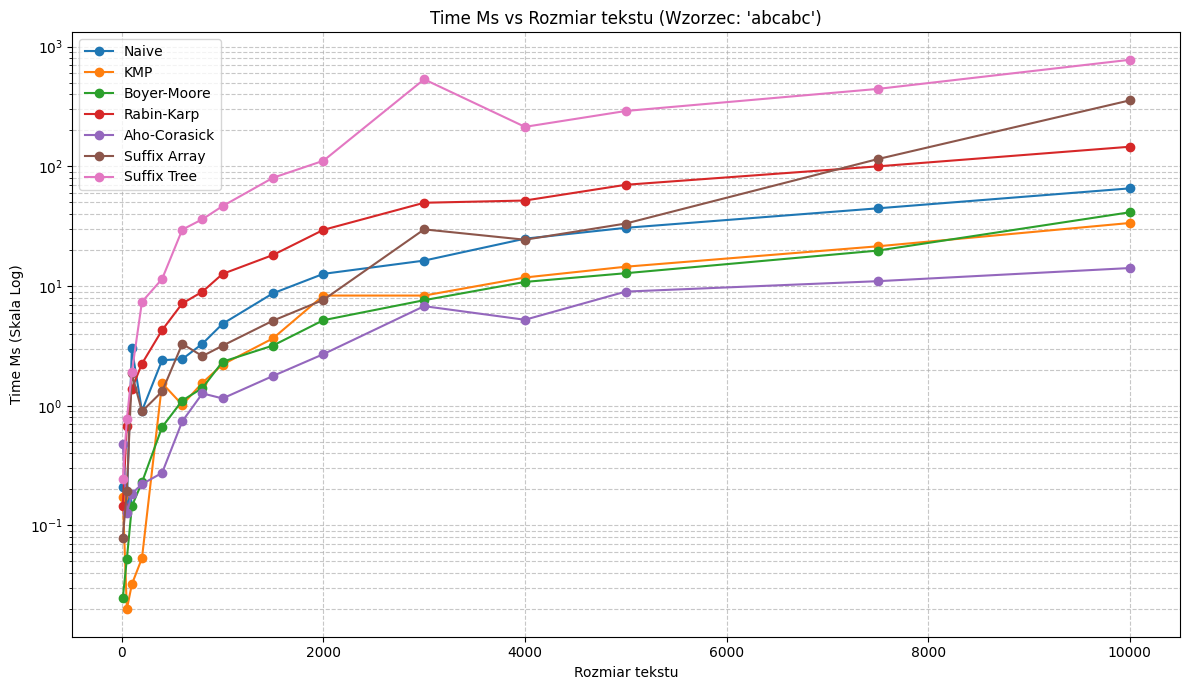

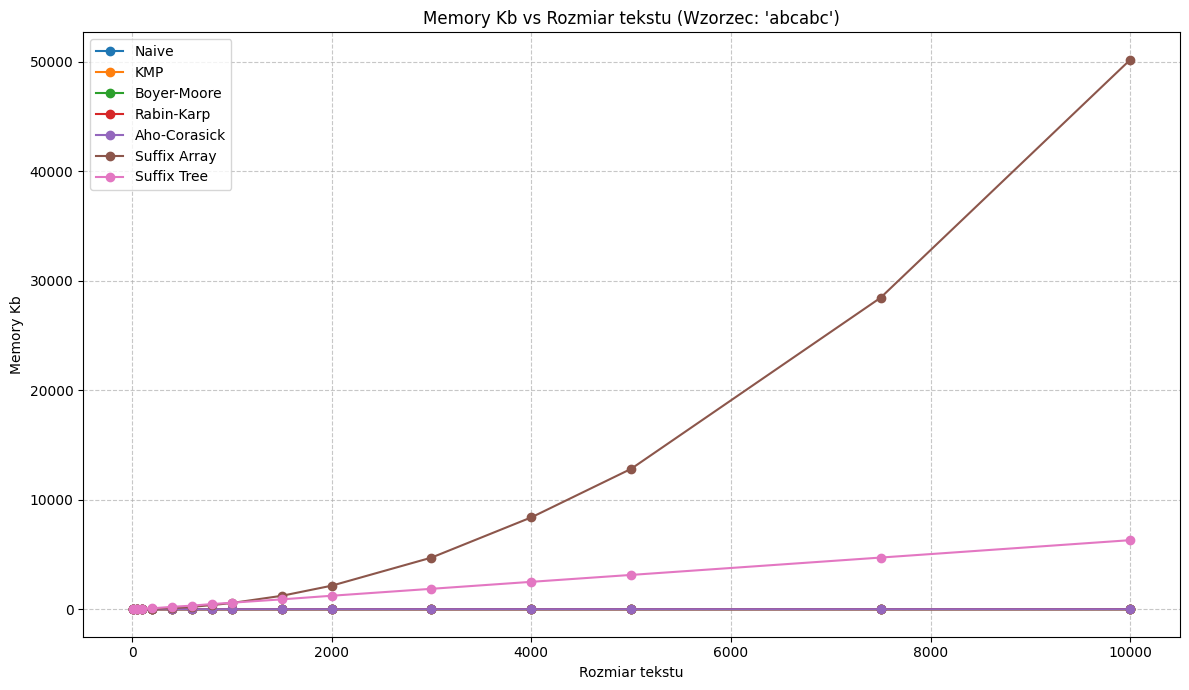

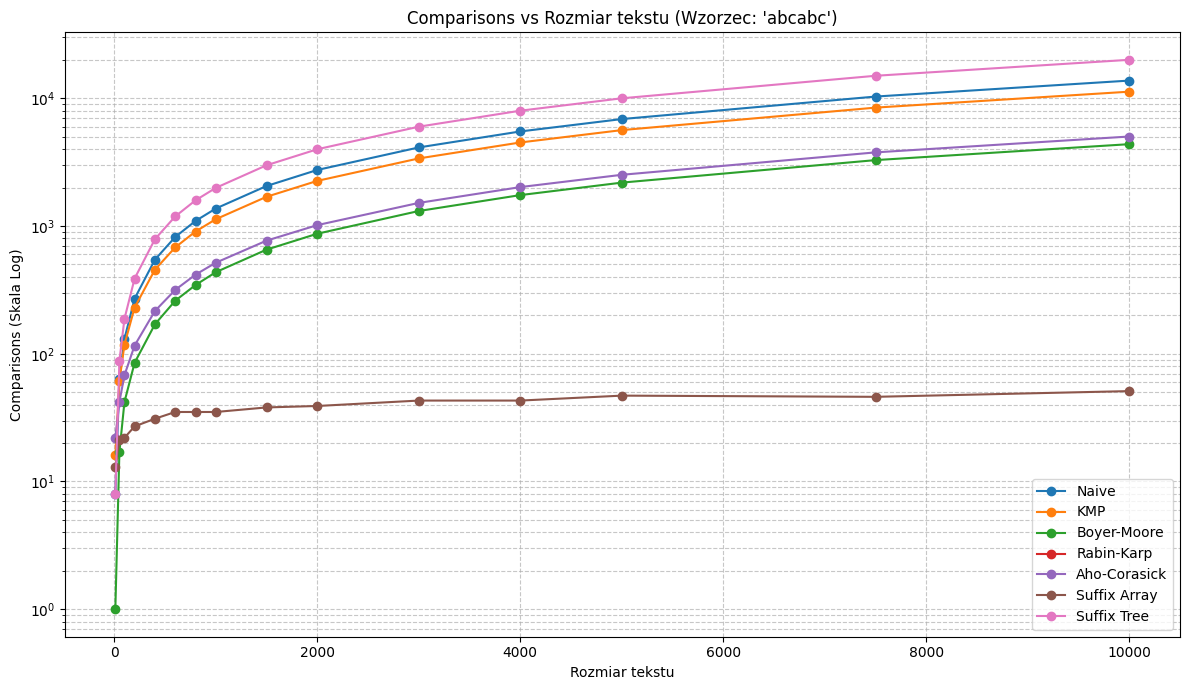


--- ANALIZA 2: Wpływ długości wzorca (tekst stały) ---

--- Porównanie dla tekstu (rozmiar: 2000), wzorca: 'ab' (długość: 2) ---

--- Porównanie dla tekstu (rozmiar: 2000), wzorca: 'abra' (długość: 4) ---

--- Porównanie dla tekstu (rozmiar: 2000), wzorca: 'abracada' (długość: 8) ---

--- Porównanie dla tekstu (rozmiar: 2000), wzorca: 'abracadabraabrac' (długość: 16) ---

--- Porównanie dla tekstu (rozmiar: 2000), wzorca: 'abracadabraabracadabraabracadabr' (długość: 32) ---

--- Porównanie dla tekstu (rozmiar: 2000), wzorca: 'abracadabraabracadabraabracadabraabracadabraabracadabraabracadab' (długość: 64) ---

--- Porównanie dla tekstu (rozmiar: 2000), wzorca: 'abracadabraabracadabraabracadabraabracadabraabracadabraabracadabraabracadabraabracadabraabracadabraabracadabraabracadabraabracad' (długość: 128) ---

--- Porównanie dla tekstu (rozmiar: 2000), wzorca: 'abracadabraabracadabraabracadabraabracadabraabracadabraabracadabraabracadabraabracadabraabracadabraabracadabraabracadabraabracad

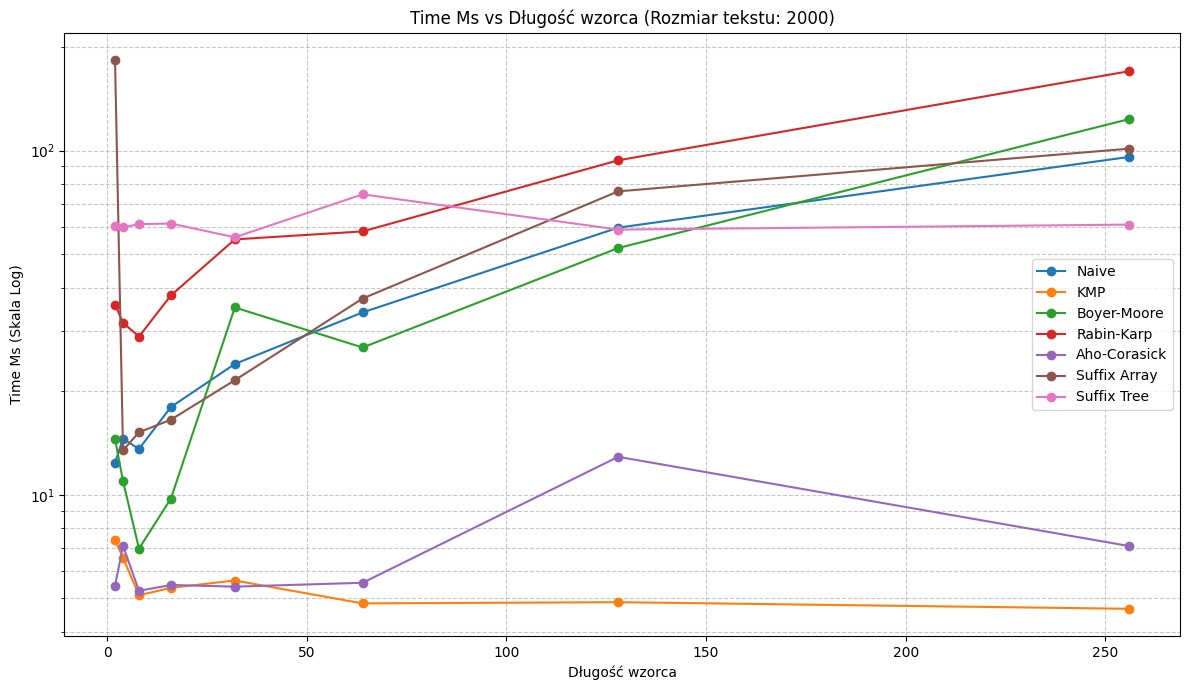

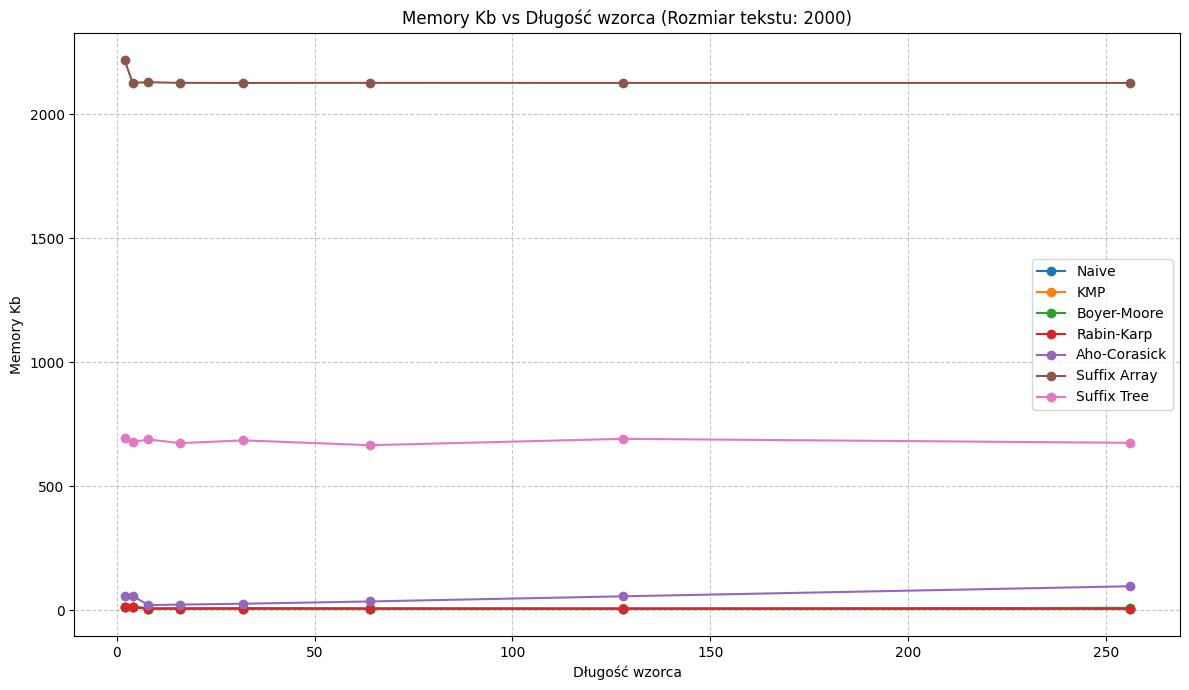

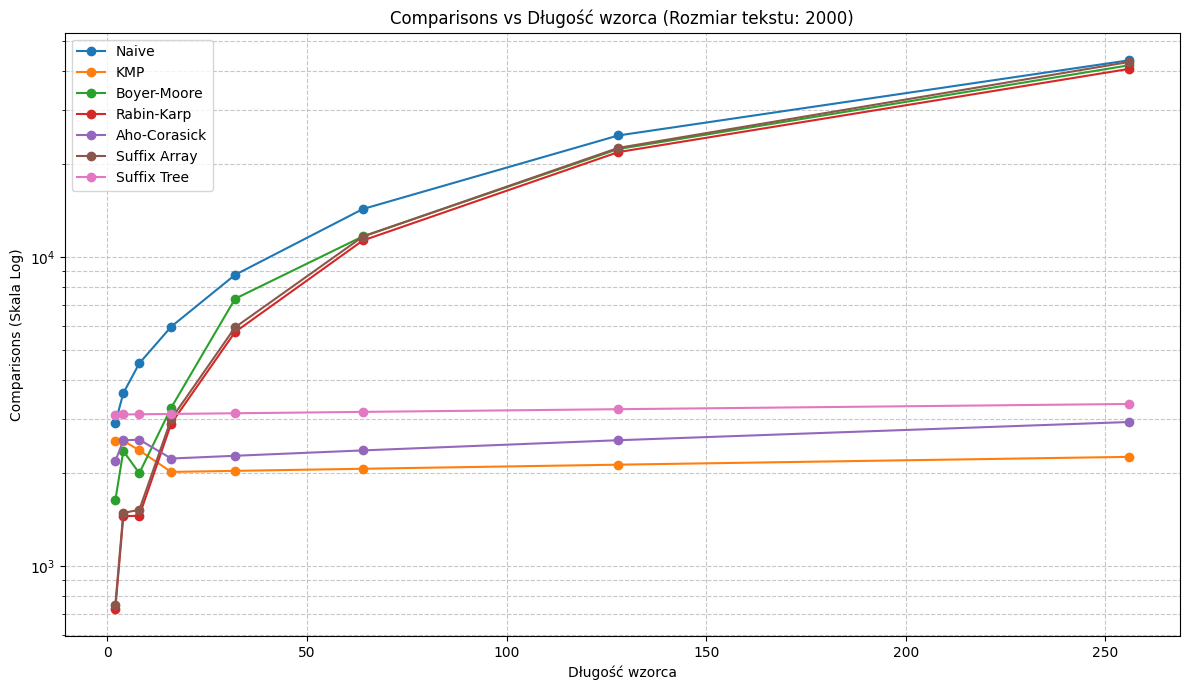

In [34]:
print("\n--- ANALIZA 1: Wpływ rozmiaru tekstu (wzorzec stały) ---")
text_sizes_analysis1 = [10, 50, 100, 200, 400, 600, 800, 1000, 1500, 2000, 3000, 4000, 5000, 7500, 10000] 
# text_sizes_analysis1 = [100, 500, 1000, 2000, 4000, 8000, 12000] 
#text_sizes_analysis1 = [100, 250, 500, 750, 1000, 1500, 2000] 
pattern_analysis1 = "abcabc" 
# pattern_analysis1 = "ababaca" 
results_all_analysis1 = {}

for size in text_sizes_analysis1:
    repeating_unit = "abcdefgh" 
    text = (repeating_unit * (size // len(repeating_unit) + 1))[:size]
    if len(text) == 0 and size > 0: text = "a"*size 
    if len(text) < len(pattern_analysis1) and size >= len(pattern_analysis1): 
        text = (pattern_analysis1 * (size // len(pattern_analysis1) +1))[:size]

    if not text and size > 0 : #
        print(f"Ostrzeżenie: Tekst dla rozmiaru {size} jest pusty. Używam 'a'*{size}.")
        text = 'a' * size
    
    if len(text) < len(pattern_analysis1):
        print(f"Ostrzeżenie: Tekst (dł: {len(text)}) jest krótszy niż wzorzec (dł: {len(pattern_analysis1)}) dla rozmiaru tekstu {size}. Pomijam.")
        continue


    current_results = compare_pattern_matching_algorithms_modified(text, pattern_analysis1)
    results_all_analysis1[size] = current_results

valid_text_sizes_for_plot = [s for s in text_sizes_analysis1 if s in results_all_analysis1 and results_all_analysis1[s]]
if valid_text_sizes_for_plot:
    first_valid_size = valid_text_sizes_for_plot[0]
    algorithm_names_analysis1 = list(results_all_analysis1[first_valid_size].keys())

    metrics_to_plot = ["time_ms", "memory_kb", "comparisons"]
    for metric in metrics_to_plot:
        plot_results_vs_size(valid_text_sizes_for_plot, pattern_analysis1, algorithm_names_analysis1, 
                             metric, results_all_analysis1, "Rozmiar tekstu", log_scale_y=(metric != "memory_kb"))
else:
    print("Brak wyników dla analizy rozmiaru tekstu do narysowania.")

print("\n--- ANALIZA 2: Wpływ długości wzorca (tekst stały) ---")
fixed_text_size_analysis2 = 2000 
# pattern_lengths_analysis2 = [2, 5, 10, 20, 50, 100, 200, 400, 500] 
pattern_lengths_analysis2 = [2, 4, 8, 16, 32, 64, 128, 256] 

base_seq = "abracadabra"
text_for_analysis2 = (base_seq * (fixed_text_size_analysis2 // len(base_seq) + 1))[:fixed_text_size_analysis2]

results_all_analysis2 = {}

for p_length in pattern_lengths_analysis2:
    if p_length == 0 : continue
    if p_length > fixed_text_size_analysis2:
        print(f"Długość wzorca {p_length} jest większa niż tekst ({fixed_text_size_analysis2}). Pomijam.")
        continue

    pattern_for_current_length = text_for_analysis2[:p_length]
    if not pattern_for_current_length :
         print(f"Ostrzeżenie: Wzorzec dla długości {p_length} jest pusty. Używam 'a'*{p_length}.")
         pattern_for_current_length = 'a' * p_length
    
    current_results = compare_pattern_matching_algorithms_modified(text_for_analysis2, pattern_for_current_length)
    results_all_analysis2[p_length] = current_results

valid_pattern_lengths_for_plot = [pl for pl in pattern_lengths_analysis2 if pl in results_all_analysis2 and results_all_analysis2[pl]]
if valid_pattern_lengths_for_plot:
    first_valid_pl = valid_pattern_lengths_for_plot[0]
    algorithm_names_analysis2 = list(results_all_analysis2[first_valid_pl].keys())
    for metric in metrics_to_plot: 
        plot_results_vs_size(valid_pattern_lengths_for_plot, str(fixed_text_size_analysis2), algorithm_names_analysis2,
                             metric, results_all_analysis2, "Długość wzorca", log_scale_y=(metric != "memory_kb"))


### Opisy i wnioski

Analiza Kompromisów:
Naiwny Algorytm:
Zalety: Niezwykle prosty w implementacji, minimalne zużycie pamięci.
Wady: Bardzo wolny dla większości przypadków , szczególnie na tekstach i wzorcach z powtórzeniami. Duża liczba porównań.
Kompromis: Prostota i minimalna pamięć kosztem drastycznie niskiej wydajności czasowej.

KMP (Knuth-Morris-Pratt):
Zalety: Gwarantowany liniowy czas wykonania. Niska liczba porównań w fazie wyszukiwania.
Wady: Wymaga preprocessingu wzorca . Może być nieco wolniejszy w praktyce od Boyer-Moore dla niektórych danych.
Kompromis: Szybki i używa mało pamięci, biorąc pod uwagę tą krótką analizę najlepszy wybór.

Boyer-Moore:
Zalety: Często najszybszy w praktyce dla pojedynczego wzorca, zwłaszcza dla długich wzorców i większych alfabetów (tutaj średnio odzwierciedlone).
Wady: Wymaga preprocessingu wzorca czasu i pamięci na tabele.
Kompromis: Złożoność preprocessingu i potencjalnie większa pamięć (niż KMP, jeśli alfabet jest duży).

Rabin-Karp:
Zalety: Prosta koncepcja, dobre średnie zachowanie czasowe , minimalna dodatkowa pamięć. Łatwo rozszerzalny do wyszukiwania wielu wzorców.
Wady: Najgorszy przypadek czasowy to O(NM) przy licznych kolizjach haszy .
Kompromis: Ryzyko słabej wydajności w najgorszym przypadku w zamian za prostotę, niskie zużycie pamięci i dobre średnie wyniki.

Aho-Corasick:
Zalety: Wyjątkowo efektywny do jednoczesnego wyszukiwania wielu wzorców. Dla jednego wzorca czas jest O(N+M+k).
Wady: Budowa automatu  może być kosztowna czasowo i pamięciowo.
Kompromis: Znaczny koszt budowy automatu i potencjalnie duże zużycie pamięci w zamian za ekstremalnie szybkie wyszukiwanie wielu wzorców jednocześnie.

Suffix Array (Tablica Sufiksów):
Zalety: Po zbudowaniu (kosztownym), wyszukiwanie jest szybkie (O(M log N) lub O(M) z LCP). Pozwala na wiele różnych zapytań dotyczących wzorców w tekście.
Wady: Budowa tablicy jest kosztowna czasowo to dużo. Zużycie pamięci to O(N).
Kompromis: Duży koszt jednorazowego (lub rzadkiego) preprocessingu całego tekstu i znaczne zużycie pamięci w zamian za bardzo szybkie wielokrotne zapytania o wzorce w tym tekście.

Suffix Tree (Drzewo Sufiksów - Ukkonen):
Zalety: Najbardziej potężna struktura. Budowa w O(N) (dla stałego alfabetu). Wyszukiwanie wzorca w O(M). Umożliwia rozwiązanie wielu zaawansowanych problemów stringologicznych.
Wady: Implementacja jest bardzo złożona i podatna na błędy. Stałe ukryte w złożoności O(N) mogą być duże(w tutejszej impelementacji widać szczególnie). 
Kompromis: Największa złożoność implementacyjna i potencjalnie wysokie stałe czasowe i pamięciowe w zamian za najlepszą teoretyczną wydajność.
